# Tara Sequencer, Unnormalized

In [1]:
# imports
from importlib import reload
import numpy as np
import pandas
import datetime

from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy

import seaborn as sns

from oceancolor.tara import io
from oceancolor.tara import spectra

import sequencer
from sequencer import sequencer_

# Load the Table

In [2]:
tara_db = io.load_tara_db()

# Process the spectra

In [3]:
reload(spectra)
wv_nm, all_a_ph, all_a_ph_sig = spectra.spectra_from_table(tara_db)
wv_grid = np.arange(402.5, 707.5, 5.)
rwv_nm, r_aph, r_sig = spectra.rebin_to_grid(wv_nm, all_a_ph, all_a_ph_sig, wv_grid)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:248: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:249: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)


# Remove bad spectra

In [5]:
tot_spec = np.nansum(r_aph, axis=-1)
gd_tot = tot_spec > 0.
cull_raph = r_aph[gd_tot, :]
cull_rsig = r_sig[gd_tot, :]

# Deal with NaN and non-zero

In [6]:
bad = np.isnan(cull_raph) | (cull_rsig <= 0.) | (cull_raph <0.)
print(f'Nbad = {np.sum(bad)}')
# Replace
cull_raph[bad] = 1e-5
cull_rsig[bad] = 1e5

Nbad = 81851


# Grab a random sequence

In [19]:
rand = np.random.choice(np.arange(cull_raph.shape[0]), size=1000, replace=False)
rand_raph = cull_raph[rand,:]

# Init

In [20]:
reload(sequencer_)
grid = np.arange(len(rwv_nm))
#estimator_list = ['EMD', 'energy', 'L2'] 
estimator_list = ['L2']
#estimator_list = ['EMD', 'L2', 'KL'] # Removed KL because of the 0 values

seq = sequencer_.Sequencer(grid, rand_raph, estimator_list, no_norm=True)

In [21]:
output_path = "/home/xavier/Projects/Oceanography/Color/Sequencer/Tara/UnNorm"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 1.3891193866729736 seconds
calculating the distance matrices for estimator: L2, scale: 2
finished calculating this distance matrix list, it took: 2.7520384788513184 seconds
dumped the distance matrix dictionaries to the file: /home/xavier/Projects/Oceanography/Color/Sequencer/Tara/UnNorm/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: L2, scale: 1
in estimator: L2, scale: 2
dumped the elongations to the file: /home/xavier/Projects/Oceanography/Color/Sequencer/Tara/UnNorm/elongations.pkl
dumped the full weighted distance matrix to the file: /home/xavier/Projects/Oceanography/Color/Sequencer/Tara/UnNorm/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='/home/xavier/Projects/Oceanography/Color/Sequencer/Tara/UnNorm/sparse_distance_matrix.pkl'>
dumped the final sequences and el

# Explore

In [22]:
# print the resulting elongation
print("resulting elongation: ", final_elongation)


# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()


print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   np.round(elongation_list[i], 2)))

resulting elongation:  30.601029999999998
intermediate elongations for the different metrics and scales:
metric=L2, scale=1, elongation: 32.16
metric=L2, scale=2, elongation: 30.6


# Grab the best

In [23]:
estimator_list, scale_list, sequence_list = seq.return_sequence_of_weighted_products_all_metrics_and_scales()
final_sequence = sequence_list[1]

# Examine

In [29]:
reorder_raph.shape

(1000, 60)

Text(0, 0.5, 'object index')

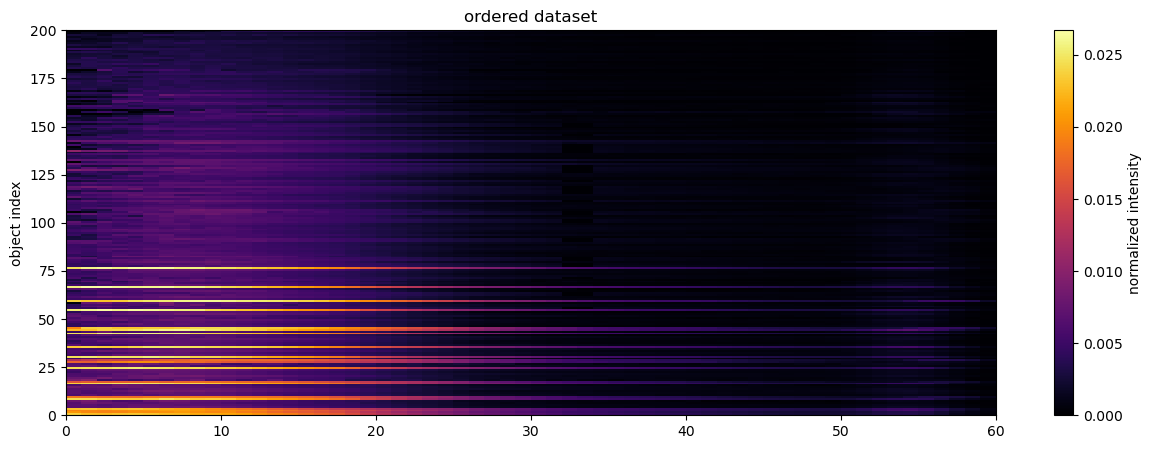

In [31]:
# plot the ordered dataset
reorder_raph = rand_raph[final_sequence, :]

plt.figure(1, figsize=(15, 5))
plt.title("ordered dataset")
#plt.pcolormesh(rand_raph, cmap="inferno")
plt.pcolormesh(reorder_raph[-200:,], cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

## Spectra

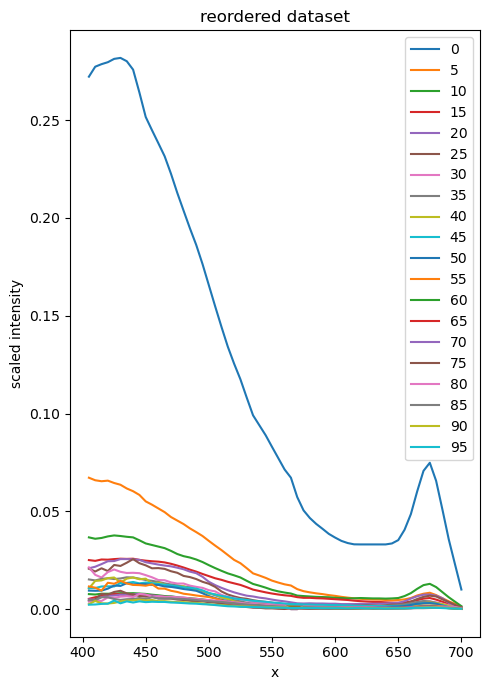

In [18]:
plt.figure(1, figsize=(5, 7))
plt.title("reordered dataset")
ax = plt.gca()
for ii in range(0,len(final_sequence),5):
    #object_data_scaled_y = object_data + i*1.5 # scale the objects so they will not be one on top of the other
    ax.plot(rwv_nm, reorder_raph[ii,:], label=f'{ii}')#, "k")
    
plt.xlabel("x")
plt.ylabel("scaled intensity")
ax.legend()
plt.tight_layout()
plt.show()